In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from google.colab import drive
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files

# Specify the path to the file you want to download
file_path = '/content/drive/MyDrive/quotes.csv'


In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

In [5]:
# Display the column names
print("Column Names:")
print(df.columns)

# Display the first few rows of the DataFrame
print("\nFirst few rows:")
print(df.head())


Column Names:
Index(['quote', 'author', 'category'], dtype='object')

First few rows:
                                               quote  \
0  I'm selfish, impatient and a little insecure. ...   
1  You've gotta dance like there's nobody watchin...   
2  You know you're in love when you can't fall as...   
3  A friend is someone who knows all about you an...   
4  Darkness cannot drive out darkness: only light...   

                                              author  \
0                                     Marilyn Monroe   
1                                  William W. Purkey   
2                                          Dr. Seuss   
3                                     Elbert Hubbard   
4  Martin Luther King Jr., A Testament of Hope: T...   

                                            category  
0  attributed-no-source, best, life, love, mistak...  
1  dance, heaven, hurt, inspirational, life, love...  
2  attributed-no-source, dreams, love, reality, s...  
3                fri

In [6]:
num_rows = df.shape[0]
print("Number of rows in the DataFrame:", num_rows)

Number of rows in the DataFrame: 499709


In [7]:
# Limit the dataset to 5000 rows
df = df.sample(1000)

In [8]:
quotes = df['quote'].drop_duplicates().dropna()
print(f"Total Unique Quotes: {quotes.shape[0]}")


Total Unique Quotes: 1000


In [9]:
# Considering only top 3000 quotes
if quotes.shape[0] > 1000:
    quotes_filt = quotes.sample(1000)
else:
    quotes_filt = quotes

In [10]:
print(f"Filtered Quotes: {quotes_filt.shape[0]}")
all_quotes = list(quotes_filt)
print(all_quotes[:2])

Filtered Quotes: 1000
['Crushes are so awful. I wonder if they suck worse for the crush-er or the crush-ee. I consider my three years of watching Josh from afar. Yeah, definitely the crush-er.', 'Sometimes, the way around prejudice is education.']


In [11]:
# Preprocessing function to clean the text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [12]:
# Apply preprocessing to all quotes
all_quotes = [preprocess_text(quote) for quote in all_quotes]

In [13]:
# Tokenization
tokenizer = Tokenizer()

In [15]:
# Function to create the sequences
def generate_sequences(corpus):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    print(f"Total unique words in the text corpus: {total_words}")
    input_sequences = []
    for line in corpus:
        seq = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(seq)):
            ngram_seq = seq[:i+1]
            input_sequences.append(ngram_seq)
    return input_sequences, total_words

In [16]:
# Generating sequences
input_sequences, total_words = generate_sequences(all_quotes)
input_sequences[:5]

Total unique words in the text corpus: 6450


[[2360, 1418],
 [2360, 1418, 605],
 [2360, 1418, 605, 1419],
 [2360, 1418, 605, 1419, 503],
 [2360, 1418, 605, 1419, 503, 1420]]

In [18]:
# Function to create the sequences
def generate_sequences(corpus, max_quotes=1000):
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    print(f"Total unique words in the text corpus: {total_words}")
    input_sequences = []

    # Limit corpus to max_quotes
    corpus = corpus[:max_quotes]

    for line in corpus:
        seq = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(seq)):
            ngram_seq = seq[:i+1]
            input_sequences.append(ngram_seq)

    return input_sequences, total_words


In [19]:
# Generating predictors and labels from the padded sequences
def generate_input_sequence(input_sequences):
    maxlen = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=maxlen)
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = to_categorical(label, num_classes=total_words)
    return predictors, label, maxlen

predictors, label, maxlen = generate_input_sequence(input_sequences)
print(f"Predictors shape: {predictors.shape}")
print(f"Label shape: {label.shape}")

Predictors shape: (17091, 272)
Label shape: (17091, 6450)


In [20]:
# Building the model
embedding_dim = 64

def create_model(maxlen, embedding_dim, total_words):
    model = Sequential()
    model.add(Embedding(total_words, embedding_dim, input_length=maxlen-1))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))

    # compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(maxlen, embedding_dim, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 272, 64)           412800    
                                                                 
 bidirectional (Bidirection  (None, 272, 256)          197632    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 272, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 6450)              832050    
                                                                 
Total params: 1639602 (6.25 MB)
Trainable params: 1639602 (6.25 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [21]:
# Training the model
history= model.fit(predictors, label, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
428/428 [==============================] - 71s 152ms/step - loss: 8.4350 - accuracy: 0.0056 - val_loss: 8.4125 - val_accuracy: 0.0076
Epoch 2/10
428/428 [==============================] - 34s 80ms/step - loss: 7.9685 - accuracy: 0.0067 - val_loss: 8.6486 - val_accuracy: 0.0064
Epoch 3/10
428/428 [==============================] - 25s 59ms/step - loss: 7.8099 - accuracy: 0.0067 - val_loss: 8.9153 - val_accuracy: 0.0076
Epoch 4/10
428/428 [==============================] - 21s 48ms/step - loss: 7.6985 - accuracy: 0.0067 - val_loss: 9.1184 - val_accuracy: 0.0070
Epoch 5/10
428/428 [==============================] - 19s 44ms/step - loss: 7.5705 - accuracy: 0.0074 - val_loss: 9.2758 - val_accuracy: 0.0056
Epoch 6/10
428/428 [==============================] - 18s 42ms/step - loss: 7.4210 - accuracy: 0.0075 - val_loss: 9.5140 - val_accuracy: 0.0070
Epoch 7/10
428/428 [==============================] - 18s 42ms/step - loss: 7.2608 - accuracy: 0.0086 - val_loss: 9.6149 - val_accuracy

In [22]:
# Function to generate quote based on input category with temperature sampling
def generate_quote(seed_text, next_words, max_sequence_len, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted = predicted.astype("float64")
        predicted = np.log(predicted + 1e-7) / temperature
        exp_preds = np.exp(predicted)
        predicted = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, predicted[0], 1)
        output_word = tokenizer.index_word[np.argmax(probas)]
        seed_text += " " + output_word
    return seed_text

In [24]:
# Example usage
seed_text = "friend"
print("Generated Quote:", generate_quote(seed_text, next_words=19, max_sequence_len=maxlen))

Generated Quote: friend pray take love questions unless could understand taken found exactly memory reach life keep kill awareness necessary regarding beauties


In [27]:
# Example usage
seed_text = "love"
print("Generated Quote:", generate_quote(seed_text, next_words=13, max_sequence_len=maxlen))

Generated Quote: love began head precedes though us taught inside world keep prayer change grant ability


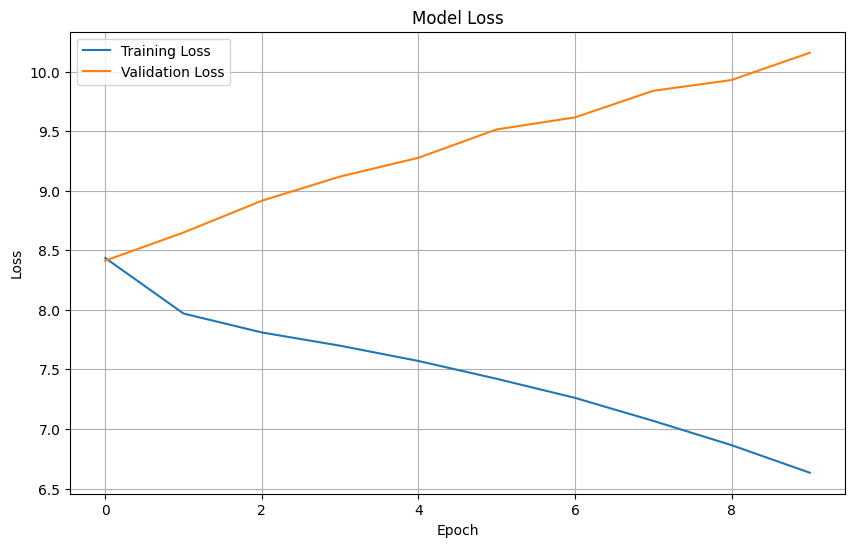

In [26]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

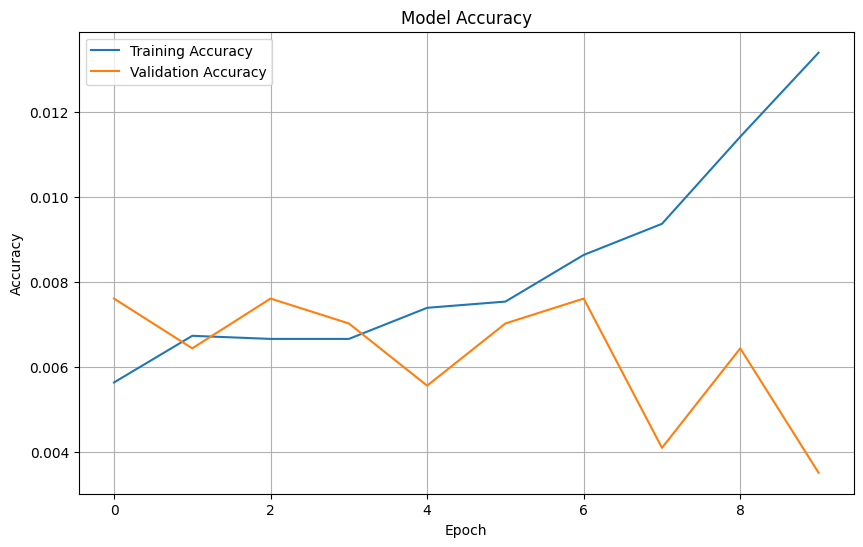

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()